In [1]:
import openmc
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
!rm *.xml
!rm *.png

# Advanced Burner Reactor

## materials

- depleted Uranium
- TRansUranic waste
  - enrichment for weapons grade plutonium is 15.5%
  - enrichment for reycled LWR-SNF (spent nuclear fuel) is 22.1%

### Depleted Uranium

In [3]:
du = openmc.Material()

du.add_nuclide("U234", 0.001, "wo")
du.add_nuclide("U235", 0.2, "wo")
du.add_nuclide("U238", 99.8, "wo")

### TRU

In [4]:
# weapons grade Pu
# 15.5% enrichment
tru_wg = openmc.Material()

tru_wg.add_nuclide("Pu238", 0.01)
tru_wg.add_nuclide("Pu239", 93.81)
tru_wg.add_nuclide("Pu240", 5.81)
tru_wg.add_nuclide("Pu241", 0.35)
tru_wg.add_nuclide("Pu242", 0.02)

In [5]:
# lwr spend nuclear fuel
# 22.1% enrichment
tru_lwr_sf = openmc.Material()

tru_lwr_sf.add_nuclide("Np237", 4.72)

tru_lwr_sf.add_nuclide("Pu238", 2.18)
tru_lwr_sf.add_nuclide("Pu239", 47.34)
tru_lwr_sf.add_nuclide("Pu240", 22.82)
tru_lwr_sf.add_nuclide("Pu241", 8.42)
tru_lwr_sf.add_nuclide("Pu242", 6.84)

tru_lwr_sf.add_nuclide("Am241", 5.62)
#tru_lwr_sf.add_nuclide("Am242m", 0.01), Am241 was increased by 0.01 to account for this
tru_lwr_sf.add_nuclide("Am243", 1.56)

tru_lwr_sf.add_nuclide("Cm243", 0.00)
tru_lwr_sf.add_nuclide("Cm244", 0.46)
tru_lwr_sf.add_nuclide("Cm245", 0.04)

### Metal Core

In [6]:
# using the weapons grade Pu for TRU
core = openmc.Material()

#enrichment_tru = 15.5 / 100
#enrichment_u = 1 - enrichment_tru

enrichment_tru = 80 / 100
enrichment_u = 1 - enrichment_tru

# uranium
core.add_nuclide("U234", 0.001 * enrichment_u)#, "wo")
core.add_nuclide("U235", 0.2 * enrichment_u)#, "wo")
core.add_nuclide("U238", 99.8 * enrichment_u)#, "wo")

# zirconium, assuming bound to U in equal proportions
core.add_element("Zr", enrichment_u)

# plutonium
core.add_nuclide("Pu238", 0.01 * enrichment_tru)
core.add_nuclide("Pu239", 93.81 * enrichment_tru)
core.add_nuclide("Pu240", 5.81 * enrichment_tru)
core.add_nuclide("Pu241", 0.35 * enrichment_tru)
core.add_nuclide("Pu242", 0.02 * enrichment_tru)

# density
core.set_density("g/cc", 20)

### fill

In [7]:
# assume natural abundance of Na
na = openmc.Material()
na.add_element("Na", 100)

### HT9, clad

In [8]:
ht9 = openmc.Material()

ht9.add_element("C", 0.16)
ht9.add_element("Si", 0.04)
ht9.add_element("Mn", 0.58)
ht9.add_element("Cr", 12.20)
ht9.add_element("Mo", 0.90)
ht9.add_element("W", 0.50)
ht9.add_element("V", 0.29)
ht9.add_element("Ni", 0.69)
ht9.add_element("S", 0.002)
ht9.add_element("P", 0.003)
ht9.add_element("N", 0.106)
ht9.add_element("Fe", 84.529)

### boron

In [9]:
boron = openmc.Material()
boron.add_element('B', 100)

### water

In [10]:
water = openmc.Material()
water.add_element('H', 2)
water.add_element('O', 1)

### testing

### xml

In [11]:
materials = openmc.Materials((core, na, ht9, tru_wg, boron, water, tru_lwr_sf))
materials.export_to_xml()

## geometry

### fuel assembly

In [12]:
# radii [cm]
pellet_diameter = 5.5685 / 10

clad_inner_diameter = 6.4300 / 10
clad_outer_diameter = 7.5500 / 10

pin_cell_f2f = 8.9074 / 10

pin_pitch = 1.180 * pellet_diameter

duct_f2f = 15.710

In [13]:
colors = {
    core : (250, 128, 114),#'salmon',
    na : 'steelblue',
    ht9 : 'darkgray',
    tru_wg : "forestgreen",
    boron : "red",
    water : "darkturquoise"
}

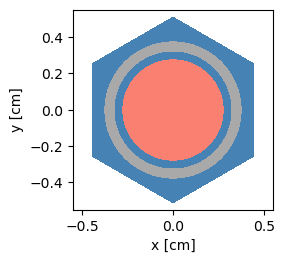

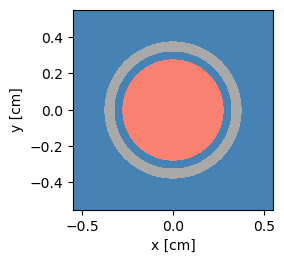

In [14]:
metal_or = openmc.ZCylinder(r = pellet_diameter / 2)
clad_ir = openmc.ZCylinder(r = clad_inner_diameter / 2)
clad_or = openmc.ZCylinder(r = clad_outer_diameter / 2)
outer_surface = openmc.model.HexagonalPrism(
    edge_length = pin_cell_f2f / 3**(.5)
)

#changing metal core to TRU
metal_cell = openmc.Cell(fill = core, region = -metal_or)
fill_cell = openmc.Cell(fill = na, region = +metal_or & -clad_ir)
clad_cell = openmc.Cell(fill = ht9, region = +clad_ir & -clad_or)
outer_cell = openmc.Cell(fill = na, region = -outer_surface)
outer_fill = openmc.Cell(fill = na, region = +clad_or)

fuel_pin = openmc.Universe(cells = [metal_cell, fill_cell, clad_cell, outer_fill])
fuel_pin_plot = openmc.Universe(cells = [metal_cell, fill_cell, clad_cell, outer_cell])

# plotting
width = 1.1

fuel_pin_plot.plot(color_by = "material", width = [width , width], colors = colors)
fuel_pin.plot(color_by = "material", width = [width , width], colors = colors)
plt.show()

In [15]:
# lattice params
fuel_assembly = openmc.HexLattice()

fuel_assembly.center = (0,0)
fuel_assembly.pitch = (pin_pitch * 3**(0.5),)
fuel_assembly.outer = openmc.Universe(cells = [openmc.Cell(fill=na)])

# filling lattice
layers = []

for i in reversed(range(1,10)):
    layers.append([fuel_pin] * (i*6))
layers.append([fuel_pin])

fuel_assembly.universes = layers
#print(fuel_assembly)

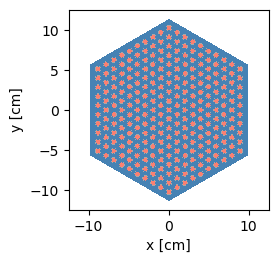

In [16]:
polygon_radius = pin_pitch * 3**(0.5) * 10
outer_hex = openmc.model.HexagonalPrism(
    edge_length = polygon_radius,
    orientation = 'y',
)

fuel_assembly_cell = openmc.Cell(fill = fuel_assembly, region = -outer_hex)

univ = openmc.Universe(cells=[fuel_assembly_cell])
univ.plot(color_by = "material", width = [25 , 25], colors = colors)
plt.show()

### outer hexagon

outer_hexagon = openmc.Cell(region=+outer_hex, fill=ht9)
univ = openmc.Universe(cells=[outer_hexagon])

univ.plot(color_by = "material", width = [100 , 100], colors = colors)
plt.show()

### blocks of TRU

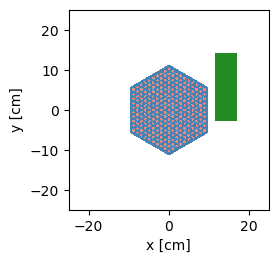

In [17]:
rect_prism = openmc.model.RectangularPrism(
    width = polygon_radius * 0.5,
    height = polygon_radius * 1.5,
    axis = 'z',
    origin = [1.25 * polygon_radius, 0.5 * polygon_radius]
)

tru_block = openmc.Cell(fill = tru_wg, region = -rect_prism)

tru_univ = openmc.Universe(cells=[fuel_assembly_cell, tru_block])
tru_univ.plot(color_by = 'material', width = [50, 50], colors=colors)
plt.show()

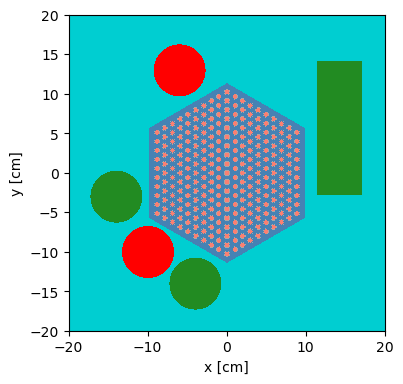

In [28]:
# boron cylins
zclin1 = openmc.ZCylinder(-10, -10, 5 * pin_pitch)
zclin2 = openmc.ZCylinder(-6, 13, 5 * pin_pitch)

boron_cell1 = openmc.Cell(fill = boron, region = -zclin1)
boron_cell2 = openmc.Cell(fill = boron, region = -zclin2)

# tru cylins
zclin3 = openmc.ZCylinder(-14, -3, 5 * pin_pitch)
zclin4 = openmc.ZCylinder(-4, -14, 5 * pin_pitch)

tru_cell1 = openmc.Cell(fill = tru_wg, region = -zclin3)
tru_cell2 = openmc.Cell(fill = tru_wg, region = -zclin4)


# bounding box
left = openmc.YPlane(y0 = -20, boundary_type = "vacuum")
right = openmc.YPlane(y0 = 20, boundary_type = "reflective")
front = openmc.XPlane(x0 = 20, boundary_type = "vacuum")
back = openmc.XPlane(x0 = -20, boundary_type = "reflective")

bounding_box = +left & -right & -front & +back
bounding_cell = openmc.Cell(fill=water, region=bounding_box)

univ = openmc.Universe(cells = [fuel_assembly_cell, tru_block, boron_cell1, boron_cell2, tru_cell1, tru_cell2, bounding_cell])
#univ = openmc.Universe(cells = [fuel_assembly_cell, bounding_cell])
univ.plot(color_by = 'material', width = [40, 40], colors=colors, pixels=100000)
plt.savefig("geometry.png", dpi=600)
plt.show()

In [29]:
main_cell = openmc.Cell(fill = univ)
geometry = openmc.Geometry([main_cell])
geometry.export_to_xml()

c = 50

plot = openmc.Plot()
plot.color_by = "material"
plot.origin = (0,0,0)
plot.geometry = geometry
plot.colors = colors
plot.width = (c,c)

plot.to_ipython_image()

## model settings

In [20]:
point1 = openmc.stats.Point((0,0,0))
#point1 = openmc.stats.Box((-19,-19,0),(19,19,0))
src1 = openmc.IndependentSource(space=point1)

settings = openmc.Settings()
settings.source = [src1]
settings.particles = 1000
settings.batches = 1000
settings.inactive = 50
settings.export_to_xml()

### tally

In [30]:
#### mesh Tally
tallies = openmc.Tallies()

mesh_len = 1000
mesh_dimensions = (mesh_len,mesh_len)

#Mesh
mesh = openmc.RegularMesh()
size = 0.2
mesh.lower_left = (-size, -size)
mesh.upper_right = (size, size)
mesh.dimension = mesh_dimensions
mesh_filter = openmc.MeshFilter(mesh)

#Different Tallies
heat = openmc.Tally()
heat.scores = ['kappa-fission']
heat.filters = [mesh_filter]

flux = openmc.Tally()
flux.scores = ['flux']
flux.filters = [mesh_filter]

#Tally XML
tallies.append(heat)
tallies.append(flux)
tallies.export_to_xml()

tallies = openmc.Tallies()

cell_filter = 

#univ.get_all_cells()
univ.get_all_materials()

In [24]:
!rm *.h5
openmc.run()
#openmc.run(output=False)

rm: cannot remove '*.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%

In [25]:
sp = openmc.StatePoint('statepoint.1000.h5')
tally = sp.get_tally()
print(tally)

Tally
	ID             =	1
	Name           =	
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True


In [26]:
#Getting the heat
heat_scores = sp.get_tally(scores=['kappa-fission'])
flux_scores = sp.get_tally(scores=['flux'])

print(heat_scores)
print(flux_scores)

#Reshaping
heat_scores.std_dev.shape = mesh_dimensions
heat_scores.mean.shape = mesh_dimensions

flux_scores.std_dev.shape = mesh_dimensions
flux_scores.mean.shape = mesh_dimensions

Tally
	ID             =	1
	Name           =	
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True
Tally
	ID             =	2
	Name           =	
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength
	Multiply dens. =	True


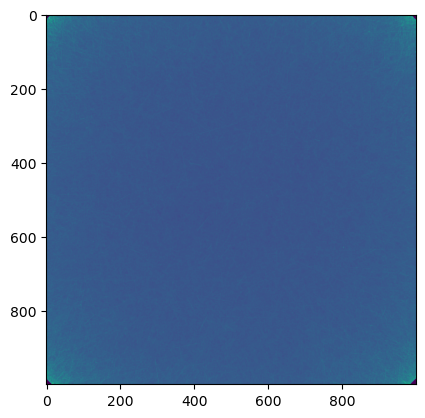

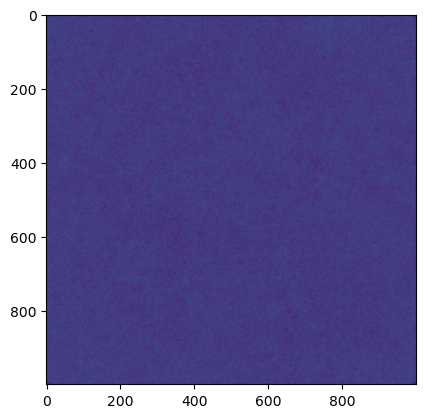

In [27]:
#Plotting
#lim = 500
fig1 = plt.subplot()
#fig1.set_xlim(500-lim,500+lim)
#fig1.set_ylim(500-lim,500+lim)
fig1.imshow(heat_scores.mean)
plt.show()

fig2 = plt.subplot()
fig2.imshow(flux_scores.mean)
plt.show()